In [ ]:
from __future__ import print_function, division
import os, random, time, copy
from skimage import io, transform, morphology, feature
import numpy as np
import os.path as path
import scipy.io as sio
from scipy import misc
from scipy import ndimage, signal
import scipy
import pickle
import sys
import math
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import PIL.Image
from io import BytesIO
from skimage import data, img_as_float
from skimage.measure import compare_ssim as ssim
from skimage.measure import compare_psnr as psnr
from skimage.draw import rectangle_perimeter
from skimage.draw import circle_perimeter
from skimage.draw import disk
import pandas as pd 
from PIL import Image

from skimage.filters import threshold_otsu, threshold_minimum
from skimage import measure
from skimage.segmentation import clear_border
from skimage.morphology import remove_small_objects
from skimage.morphology import convex_hull_object
from skimage.morphology import binary_erosion
from skimage.morphology import square
from skimage.morphology import binary_opening
from skimage.morphology import binary_closing
from skimage.morphology import binary_dilation
from skimage.morphology import convex_hull_image

from utils.flow_functions import *

import warnings # ignore warnings
warnings.filterwarnings("ignore")
print(sys.version)
print(torch.__version__)

3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 13:42:17) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
1.8.0


In [ ]:
path_to_imdb = '/Users/jtfeng/Documents/MS_Thesis/Annotations/UtrechtPollen_imdb_smallGrains.xlsx'
imdb = pd.read_excel(path_to_imdb, dtype=object)

In [ ]:
imgList = imdb['FolderName'].to_numpy()
imgWindow = imdb['Img Window'].to_numpy()
tileID = imdb['TileId'].to_numpy()
Code = imdb['Code'] 

# len(list(imgList))
print(len(imgList))

216


In [ ]:
def create_circular_mask(mask, center, radius, value=1):
    h, w = mask.shape[:2]
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((Y - center[0])**2 + (X-center[1])**2)

    tmpMask = dist_from_center <= radius
    mask[tmpMask] = value
    
    return mask

# Find all border grains

In [ ]:
path_to_image = '/Volumes/My Passport for Mac/UTRECHT/Training_Tiles3'

border = set([])

for idx in range(len(imgList)):    
    img_win_folder = imgList[idx] + "_" + str(imgWindow[idx])

    path_to_small_imdb = path.join(path_to_image, img_win_folder, csv_name)
    imdb2 = pd.read_csv(path_to_small_imdb, dtype=object)

    tileID = imdb2['TileId'].to_numpy()
    relX = imdb2['X Coord of Bb'].to_numpy()
    relY = imdb2['Y Coord of Bb'].to_numpy()
    BBWidth = imdb2['Bb Width'].to_numpy()
    BBHeight = imdb2['Bb Height'].to_numpy()
    Family = imdb2['Family'].to_numpy()
    SpeciesID = imdb2['SpeciesId'].to_numpy()
    TileHeight = imdb2[' hPixels'].to_numpy()
    TileWidth = imdb2[' wPixels'].to_numpy()

    protoMask = pd.DataFrame(imdb2, columns = ['X Coord of Bb','Y Coord of Bb','Bb Width','Bb Height'])
    img_name = "Tile"+ tileID[0].zfill(6)+".bmp"
    img_path=path.join(path_to_image, img_win_folder, img_name)

    ImgWinMask = protoMask.to_numpy().astype(int)

    for pollen in ImgWinMask:
        XCoordBb_start = pollen[0]
        XCoordBb_end = pollen[0] + pollen[3]
        YCoordBb_start = pollen[1]
        YCoordBb_end = pollen[1] + pollen[2]

        if int(pollen[0])<=2 or \
        int(pollen[1])<=2 or \
        int(TileWidth[0]) - int(pollen[0]+(pollen[3]))<=2 or \
        int(TileHeight[0]) - int(pollen[1]+(pollen[2]))<= 2:
            border.add(idx)

In [ ]:
print(len(border))
border = list(border)
print(border[0:10])
# print(sorted(border))

33
[129, 3, 4, 132, 134, 12, 16, 17, 18, 19]


In [ ]:
print(sorted(border)[30:])
print(len(border))

[195, 199, 206]
33


# Check masks

In [ ]:
idx = 206   #1997   # 57  #203  #103 #500, 501 

#2852(PALIV_B_Sample_31-32_scan2_127) deleted
#3597 PALIV_45-46_glycerine_slide 1_scan2_133 delete

path_to_save = '/Volumes/My Passport for Mac/UTRECHT/Training_Tiles3'
img_win_folder = imgList[idx] + "_" + str(imgWindow[idx])
csv_name = "annot3.csv"
print(img_win_folder)

path_to_small_imdb = path.join(path_to_save, img_win_folder, csv_name)
imdb2 = pd.read_csv(path_to_small_imdb, dtype=object)

tileID = imdb2['TileId'].to_numpy()
relX = imdb2['X Coord of Bb'].to_numpy()
relY = imdb2['Y Coord of Bb'].to_numpy()
BBWidth = imdb2['Bb Width'].to_numpy()
BBHeight = imdb2['Bb Height'].to_numpy()
Family = imdb2['Family'].to_numpy()
Genus = imdb2['Genus'].to_numpy()
Species = imdb2['Species'].to_numpy()
SpeciesID = imdb2['SpeciesId'].to_numpy()
TileHeight = imdb2[' hPixels'].to_numpy()
TileWidth = imdb2[' wPixels'].to_numpy()
SpeciesCode= imdb2['Code'] #.to_numpy()

PALIV_36-37_slide 1_scan1_385


In [ ]:
protoMask = pd.DataFrame(imdb2, columns = ['X Coord of Bb','Y Coord of Bb','Bb Width','Bb Height'])
labels=pd.DataFrame(imdb2, columns=['Code', 'Family','Genus','Species'])
img_name = "Tile"+ tileID[0].zfill(6)+".bmp"
img_path=path.join(path_to_save, img_win_folder, img_name)

ImgWinMask = protoMask.to_numpy().astype(int)
ImgWinLabels= labels.to_numpy()

image = PIL.Image.open(img_path)
image = np.array(image)
image_wLabel = np.array(image)

print(img_name)
print(img_path)
print(protoMask)
print(labels)

Tile003462.bmp
/Volumes/My Passport for Mac/UTRECHT/Training_Tiles3/PALIV_36-37_slide 1_scan1_385/Tile003462.bmp
  X Coord of Bb Y Coord of Bb Bb Width Bb Height
0           932           869      171       171
  Code               Family Genus Species
0  u/m  urticaceae-moraceae     -       -


In [ ]:
for pollen in ImgWinMask:
    Xcoord = int(pollen[0]+(0.5*pollen[3]))
    Ycoord = int(pollen[1]+(0.5*pollen[2]))
    radius = int(min(0.5*pollen[2],0.5*pollen[3]))
    if (Ycoord + radius)>=int(TileHeight[0]):
        radius = int(min(0.5*pollen[2],0.5*pollen[3]))-1
    if(Xcoord + radius)>=int(TileWidth[0]):
        radius= int(min(0.5*pollen[2],0.5*pollen[3]))-1
    print(radius, Xcoord, Ycoord)
    rr, cc = circle_perimeter(Ycoord, Xcoord, radius)
    image_wLabel[rr, cc] = 1

85 1017 954


(1040, 1392, 3)

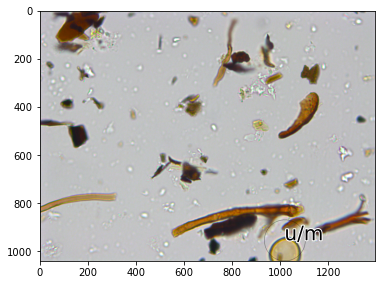

In [ ]:
plt.figure(figsize=(6,6))
for pollen, labels in zip(ImgWinMask,ImgWinLabels):
    Xcoord = int(pollen[0]+(0.5*pollen[3]))
    Ycoord = int(pollen[1]+(0.5*pollen[2]))
    plt.text(Xcoord, Ycoord, labels[0],
             fontsize=20,
             color='black', path_effects=[path_effects.withStroke(linewidth=2, foreground="w")])
plt.imshow(image_wLabel)
image_wLabel.shape

In [ ]:
label = np.zeros_like(image)   
label = label[:,:,0]
# plt.imshow(label)

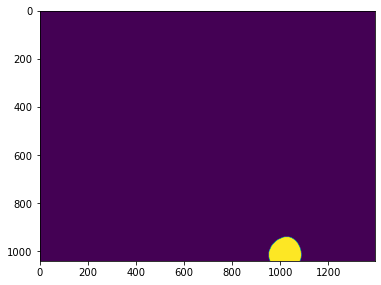

In [ ]:
for pollen in ImgWinMask:
    
    XCoordBb_start = pollen[0]
    XCoordBb_end = pollen[0] + pollen[3]
    YCoordBb_start = pollen[1]
    YCoordBb_end = pollen[1] + pollen[2]
#     print(YCoordBb_end)
    
    Xcoord = int(pollen[0]+(0.5*pollen[3]))
    Ycoord = int(pollen[1]+(0.5*pollen[2]))
    radius = int(min(0.5*pollen[2],0.5*pollen[3]))
    
    #if pollen is a border grain
    if int(pollen[0])<=2 or \
    int(pollen[1])<=2 or \
    int(TileWidth[0]) - int(pollen[0]+(pollen[3]))<=2 or \
    int(TileHeight[0]) - int(pollen[1]+(pollen[2]))<= 2:
        if int(pollen[0])<=2: 
            XCoordBb_start = 0
        if int(pollen[1])<=2:
            YCoordBb_start = 0
        if int(TileWidth[0]) - int(pollen[0]+(pollen[3]))<=2:
            XCoordBb_end = label.shape[1]
        if int(TileHeight[0]) - int(pollen[1]+(pollen[2]))<= 2:
            YCoordBb_end = label.shape[0]  
        
        imCrop = image[YCoordBb_start:YCoordBb_end, XCoordBb_start:XCoordBb_end, :]

        imCropGray = np.mean(imCrop, 2) # convert to greyscale

        thresh = threshold_otsu(imCropGray) 
        binary = imCropGray > thresh # binarize
        inv_binary = 1-binary

        label_image = measure.label(inv_binary, background=0) #label the connected components
        props = measure.regionprops(np.squeeze(label_image)) #get the properties of the connected components

        area_filled = [prop.filled_area for prop in props] # filled area of connected components
        bbox = [prop.bbox for prop in props]   #bounding box coordinates for connected components

        largest_cc_idx = np.argmax(area_filled)   #find the largest connected component
        largest_cc_img = props[largest_cc_idx].filled_image # get the filled image of the largest cc
        largest_cc_bbox = bbox[largest_cc_idx]    #[min_row, min_col, max_row, max_col]

        tmpPollenLabel = np.zeros_like(inv_binary)
        tmpPollenLabel[largest_cc_bbox[0]:largest_cc_bbox[2], largest_cc_bbox[1]:largest_cc_bbox[3]] = largest_cc_img

        opening = binary_opening(tmpPollenLabel,square(5)) #operation to get rid of small protrusions/noise
        closing = binary_closing(opening,square(5)) #operation to get rid of small holes 
        chull = convex_hull_image(closing)
        
        label[YCoordBb_start:YCoordBb_end, XCoordBb_start:XCoordBb_end] = chull
    else:
        Xcoord = int(pollen[0]+(0.5*pollen[3]))
        Ycoord = int(pollen[1]+(0.5*pollen[2]))
        radius = int(min(0.5*pollen[2],0.5*pollen[3]))
    #             if int(pollen[0])!=0 and int(pollen[1])!=0 and int(pollen[0]+(pollen[3]))<int(TileWidth[0]) and int(pollen[1]+(pollen[2]))<int(TileHeight[0]):
        rr, cc = disk((Ycoord, Xcoord), radius)
        print(radius)
        label[rr, cc] = 1
    
    
plt.figure(figsize=(6,6))
plt.imshow(label)

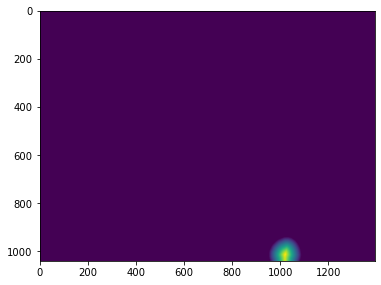

In [ ]:
# find the distance transform

mask_distanceTransform = ndimage.distance_transform_edt(label)

plt.figure(figsize=(6,6))
plt.imshow(mask_distanceTransform)

1013 1018


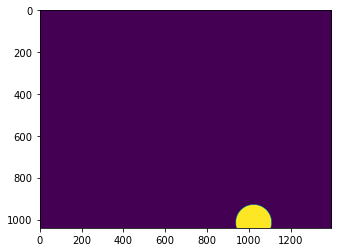

In [ ]:
label = image*0
label = label[:,:,0]

for pollen in ImgWinMask:
    
    XCoordBb_start = pollen[0]
    XCoordBb_end = pollen[0] + pollen[3]
    YCoordBb_start = pollen[1]
    YCoordBb_end = pollen[1] + pollen[2]
    
    Xcoord = int(pollen[0]+(0.5*pollen[3]))
    Ycoord = int(pollen[1]+(0.5*pollen[2]))
    radius = int(min(0.5*pollen[2],0.5*pollen[3]))
    
    #if pollen is a border grain
    if int(pollen[0])<=2 or \
    int(pollen[1])<=2 or \
    int(TileWidth[0]) - int(pollen[0]+(pollen[3]))<=2 or \
    int(TileHeight[0]) - int(pollen[1]+(pollen[2]))<= 2:
        if int(pollen[0])<=2: 
            XCoordBb_start = 0
        if int(pollen[1])<=2:
            YCoordBb_start = 0
        if int(TileWidth[0]) - int(pollen[0]+(pollen[3]))<=2:
            XCoordBb_end = label.shape[1]
        if int(TileHeight[0]) - int(pollen[1]+(pollen[2]))<= 2:
            YCoordBb_end = label.shape[0]  
        
        imCrop = mask_distanceTransform[YCoordBb_start:YCoordBb_end, XCoordBb_start:XCoordBb_end]
        coord_peaks = feature.peak_local_max(imCrop, exclude_border=False, num_peaks=1)
        y, x = coord_peaks[0]
        
        Ynew = y + YCoordBb_start
        Xnew = x + XCoordBb_start
        
        print(Ynew, Xnew)
        radius = int(min(0.5*pollen[2],0.5*pollen[3]))

        label = create_circular_mask(label, [Ynew,Xnew], radius, value=1)
        
    else:
        Xcoord = int(pollen[0]+(0.5*pollen[3]))
        Ycoord = int(pollen[1]+(0.5*pollen[2]))
        radius = int(min(0.5*pollen[2],0.5*pollen[3]))
    #             if int(pollen[0])!=0 and int(pollen[1])!=0 and int(pollen[0]+(pollen[3]))<int(TileWidth[0]) and int(pollen[1]+(pollen[2]))<int(TileHeight[0]):
        rr, cc = disk((Ycoord, Xcoord), radius)
        label[rr, cc] = 1
    

# print(radius)
plt.imshow(label)

# If necessary, fix masks

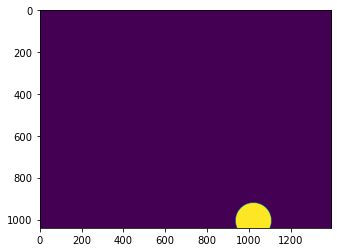

In [ ]:
label = np.zeros_like(image)   
label = label[:,:,0]

for i in range(len(ImgWinMask)):
    pollen = ImgWinMask[i]
    Xcoord = int(pollen[0]+(0.5*pollen[3]))
    Ycoord = int(pollen[1]+(0.5*pollen[2]))
    radius = int(min(0.5*pollen[2],0.5*pollen[3]))
    
    if i == 0:
        Xcoord = int(pollen[0]+(0.5*pollen[3]))
        Ycoord = int(pollen[1]+(0.5*pollen[2]))+50
        radius = int(min(0.5*pollen[2],0.5*pollen[3]))
        
    if i == 1:
        Xcoord = int(pollen[0]+(0.5*pollen[3]))-30
        Ycoord = int(pollen[1]+(0.5*pollen[2]))
        radius = int(min(0.5*pollen[2],0.5*pollen[3]))
        
    if i == 2:
        Xcoord = int(pollen[0]+(0.5*pollen[3]))
        Ycoord = int(pollen[1]+(0.5*pollen[2]))
        radius = int(min(0.5*pollen[2],0.5*pollen[3]))
        
    if i == 4:
        Xcoord = int(pollen[0]+(0.5*pollen[3]))-70
        Ycoord = int(pollen[1]+(0.5*pollen[2]))
        radius = int(min(0.5*pollen[2],0.5*pollen[3]))
    
    label = create_circular_mask(label, [Ycoord, Xcoord], radius, value=1)
    plt.imshow(label)

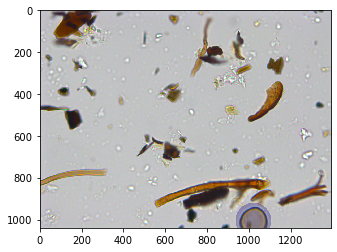

In [ ]:
masked = np.ma.masked_where(label == 0, label)
plt.imshow(image, interpolation='none')
plt.imshow(masked, 'jet', interpolation='none', alpha=0.3)    #'jet' also works as color

1004 1017


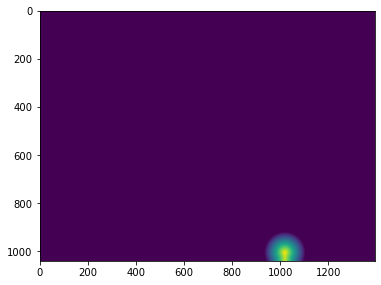

In [ ]:
mask_distanceTransform = ndimage.distance_transform_edt(label)
num_peaks = len(ImgWinMask)
coord_peaks = feature.peak_local_max(mask_distanceTransform, min_distance=25, exclude_border=False, num_peaks = num_peaks)
mask_peaks = label*0.
mask_radius = label*0.
mask_voteX = label*0.
mask_voteY = label*0.
mask_overlap = label*0.
r_list = []
annot = dict()
annot['size'] = label.shape
for i in range(coord_peaks.shape[0]):
    y, x = coord_peaks[i]
    print(y,x)
    r = mask_distanceTransform[y, x]
    r_list += [r]
    #mask_peaks[y-10:y+10, x-10:x+10] = 1
    #mask_radius[y-10:y+10, x-10:x+10] = r
    mask_peaks[y, x] = 1
    mask_radius[y, x] = r

    #tmpmask_vote = np.zeros((image.shape[0], image.shape[1]))
    mask_x, mask_y = np.asarray(range(label.shape[1])).astype(np.float), np.asarray(range(label.shape[0])).astype(np.float)
    mask_x, mask_y = np.meshgrid(mask_x, mask_y)
    mask_x = float(x) - mask_x
    mask_y = float(y) - mask_y

    tmpmask_vote = mask_x*mask_x + mask_y*mask_y <= r*r
    mask_voteX[tmpmask_vote] = mask_x[tmpmask_vote]
    mask_voteY[tmpmask_vote] = mask_y[tmpmask_vote]
    mask_overlap += tmpmask_vote.astype(np.float)
mask_overlap = mask_overlap>1
mask_overlap = mask_overlap.astype(np.uint8)    

annot['coord_peaks'] = coord_peaks
annot['mask_radius'] = r_list

plt.figure(figsize=(6,6))
plt.imshow(mask_distanceTransform)

In [ ]:
path_to_label = '/Volumes/My Passport for Mac/UTRECHT/Masks10_smallGrains'
path_to_save = '/Volumes/My Passport for Mac/UTRECHT/AnnotCombo10_smallGrains'

In [ ]:
img_win_folder = imgList[idx] + "_" + str(imgWindow[idx])
# csv_name = "annot.csv"
gt_path = path.join(path_to_label, img_win_folder,'GT_distTransform.bmp')

#Save pickle file
filename, file_extension = os.path.splitext(os.path.basename(img_path))
pkl_filename = path.join(path_to_save, img_win_folder, 'GT.pkl')
with open(pkl_filename, 'wb') as handle:
    pickle.dump(annot, handle) # , protocol=pickle.HIGHEST_PROTOCOL

#Save heatmap mask
mask_distanceTransform = mask_distanceTransform.astype(np.uint8)
im = Image.fromarray(mask_distanceTransform)
im.save(gt_path)

# Check exported mask

Text(0.5, 1.0, 'image')

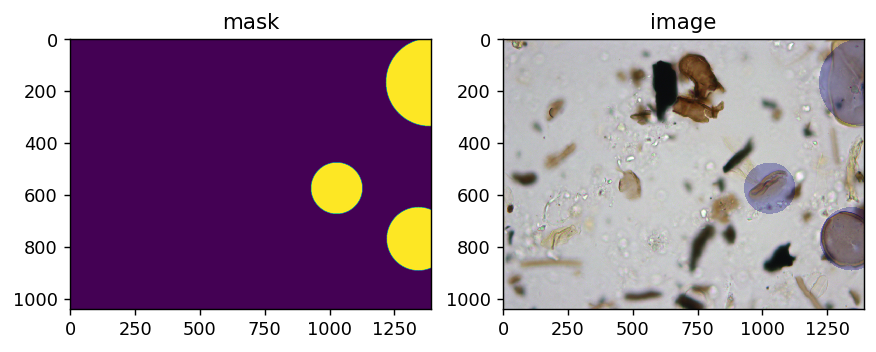

In [ ]:
path_to_mask = '/Volumes/My Passport for Mac/UTRECHT/Masks9_noNPP_circleMask'
img_win_folder = imgList[idx] + "_" + str(imgWindow[idx])
# csv_name = "annot.csv"
gt_path = path.join(path_to_mask, img_win_folder,'GT_distTransform.bmp')

mask = PIL.Image.open(gt_path)
mask = np.array(mask)
mask = mask >0

numSample2Show = 1
figWinNumHeight, figWinNumWidth = 2, 2
plt.figure(figsize=(8, 8), dpi=128, facecolor='w', edgecolor='k') # figsize -- inch-by-inch
plt.clf()
subwinCount = 1    


plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
plt.imshow(mask)
#plt.axis('off')
plt.title('mask')


plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
masked = np.ma.masked_where(mask == 0, mask)
plt.imshow(image, interpolation = 'none')
plt.imshow(masked, 'jet', interpolation='none', alpha=0.3)    #'jet' also works as color
#plt.axis('off')
plt.title('image')
# plt.colorbar()


# Automated revision of masks for images with border grains

In [ ]:
path_to_image = '/Volumes/My Passport for Mac/UTRECHT/Training_Tiles3'
path_to_label = '/Volumes/My Passport for Mac/UTRECHT/Masks10_smallGrains'
path_to_save = '/Volumes/My Passport for Mac/UTRECHT/AnnotCombo10_smallGrains'

if not os.path.exists(path_to_label): 
    os.makedirs(path_to_label)

if not os.path.exists(path_to_save): 
    os.makedirs(path_to_save)

In [ ]:
for idx in range(len(list(imgList))): 
    img_win_folder = imgList[idx] + "_" + str(imgWindow[idx])
    csv_name = "annot3.csv"
    
    gt_path = path.join(path_to_label, img_win_folder,'GT_distTransform.bmp')
    if os.path.exists(gt_path):
        continue
    
    path_to_small_imdb = path.join(path_to_image, img_win_folder, csv_name)
    imdb2 = pd.read_csv(path_to_small_imdb, dtype=object)

    tileID = imdb2['TileId'].to_numpy()
    relX = imdb2['X Coord of Bb'].to_numpy()
    relY = imdb2['Y Coord of Bb'].to_numpy()
    BBWidth = imdb2['Bb Width'].to_numpy()
    BBHeight = imdb2['Bb Height'].to_numpy()
    Family = imdb2['Family'].to_numpy()
    SpeciesID = imdb2['SpeciesId'].to_numpy()
    TileHeight = imdb2[' hPixels'].to_numpy()
    TileWidth = imdb2[' wPixels'].to_numpy()

    protoMask = pd.DataFrame(imdb2, columns = ['X Coord of Bb','Y Coord of Bb','Bb Width','Bb Height'])
    img_name = "Tile"+ tileID[0].zfill(6)+".bmp"
    img_path=path.join(path_to_image, img_win_folder, img_name)

    ImgWinMask = protoMask.to_numpy().astype(int)

    image = PIL.Image.open(img_path)
    image = np.array(image)
    
    label = np.zeros_like(image)
    label = label[:,:,0]  #Convert numpy array to single channel greyscale (it is currently RGB)
    for pollen in ImgWinMask:
        XCoordBb_start = pollen[0]
        XCoordBb_end = pollen[0] + pollen[3]
        YCoordBb_start = pollen[1]
        YCoordBb_end = pollen[1] + pollen[2]

        if int(pollen[0])==0 or \
        int(pollen[1])==0 or \
        int(pollen[0]+(pollen[3]))>=int(TileWidth[0]) or \
        int(pollen[1]+(pollen[2]))>=int(TileHeight[0]): 
            imCrop = image[YCoordBb_start:YCoordBb_end, XCoordBb_start:XCoordBb_end, :]
            imCropGray = np.mean(imCrop, 2) # convert to greyscale

            thresh = threshold_otsu(imCropGray) 
            binary = imCropGray > thresh # binarize

            inv_binary = 1-binary

            label_image = measure.label(inv_binary, background=0) #label the connected components
            props = measure.regionprops(np.squeeze(label_image)) #get the properties of the connected components

            area_filled = [prop.filled_area for prop in props]
            bbox = [prop.bbox for prop in props]

            largest_cc_idx = np.argmax(area_filled)
            largest_cc_img = props[largest_cc_idx].filled_image # get the filled version of the largest cc
            largest_cc_bbox = bbox[largest_cc_idx]    #[min_row, min_col, max_row, max_col]

            tmpPollenLabel = np.zeros_like(inv_binary)
            tmpPollenLabel[largest_cc_bbox[0]:largest_cc_bbox[2], largest_cc_bbox[1]:largest_cc_bbox[3]] = largest_cc_img

            opening = binary_opening(tmpPollenLabel,square(5)) #operation to get rid of small protrusions/noise
            closing = binary_closing(opening,square(5)) #operation to get rid of small holes 
            chull = convex_hull_image(closing)

            label[YCoordBb_start:YCoordBb_end, XCoordBb_start:XCoordBb_end] = chull

        else:
            Xcoord = int(pollen[0]+(0.5*pollen[3]))
            Ycoord = int(pollen[1]+(0.5*pollen[2]))
            radius = int(min(0.5*pollen[2],0.5*pollen[3]))
#             if int(pollen[0])!=0 and int(pollen[1])!=0 and int(pollen[0]+(pollen[3]))<int(TileWidth[0]) and int(pollen[1]+(pollen[2]))<int(TileHeight[0]):
            rr, cc = disk((Ycoord, Xcoord), radius)
            label[rr, cc] = 1
    
        curImageName = img_path
    
    if idx%50==0:
        print(idx, curImageName)
    
    
    tmpdir = path.join(path_to_save, img_win_folder)
    if not os.path.exists(tmpdir): 
        os.makedirs(tmpdir)
    tmpdir2 = path.join(path_to_label, img_win_folder)
    if not os.path.exists(tmpdir2): 
        os.makedirs(tmpdir2)
        
    # create distance transform
    mask_distanceTransform = ndimage.distance_transform_edt(label)
    
    #step 3 create circle mask
    label = image*0
    label = label[:,:,0]
    
    for pollen in ImgWinMask:
        XCoordBb_start = pollen[0]
        XCoordBb_end = pollen[0] + pollen[3]
        YCoordBb_start = pollen[1]
        YCoordBb_end = pollen[1] + pollen[2]

        Xcoord = int(pollen[0]+(0.5*pollen[3]))
        Ycoord = int(pollen[1]+(0.5*pollen[2]))
        radius = int(min(0.5*pollen[2],0.5*pollen[3]))

        #if pollen is a border grain
        if int(pollen[0])<=2 or \
        int(pollen[1])<=2 or \
        int(TileWidth[0]) - int(pollen[0]+(pollen[3]))<=2 or \
        int(TileHeight[0]) - int(pollen[1]+(pollen[2]))<= 2:
            if int(pollen[0])<=2: 
                XCoordBb_start = 0
            if int(pollen[1])<=2:
                YCoordBb_start = 0
            if int(TileWidth[0]) - int(pollen[0]+(pollen[3]))<=2:
                XCoordBb_end = label.shape[1]
            if int(TileHeight[0]) - int(pollen[1]+(pollen[2]))<= 2:
                YCoordBb_end = label.shape[0]  

            imCrop = mask_distanceTransform[YCoordBb_start:YCoordBb_end, XCoordBb_start:XCoordBb_end]
            coord_peaks = feature.peak_local_max(imCrop, exclude_border=False, num_peaks=1)
            y, x = coord_peaks[0]

            Ynew = y + YCoordBb_start
            Xnew = x + XCoordBb_start

#             tmpCrop=imCrop
#             thresh = threshold_otsu(tmpCrop) 
#             tmpCrop = tmpCrop> thresh # binarize
#             tmpCrop= measure.label(tmpCrop, background=0)
#             props = measure.regionprops(tmpCrop) #get the properties of the connected components

#             diameter = [prop.equivalent_diameter for prop in props]  #diameter for connected components
    #         diameter = [prop.major_axis_length for prop in props]   #diameter for connected components

#             radius = int(max(diameter))
            radius = int(min(0.5*pollen[2],0.5*pollen[3]))

            label = create_circular_mask(label, [Ynew,Xnew], radius, value=1)

        else:
            Xcoord = int(pollen[0]+(0.5*pollen[3]))
            Ycoord = int(pollen[1]+(0.5*pollen[2]))
            radius = int(min(0.5*pollen[2],0.5*pollen[3]))
            rr, cc = disk((Ycoord, Xcoord), radius)
            label[rr, cc] = 1
    
    mask_distanceTransform = ndimage.distance_transform_edt(label)
    num_peaks = len(ImgWinMask)
    coord_peaks = feature.peak_local_max(mask_distanceTransform, min_distance=25, exclude_border=False, num_peaks = num_peaks)
    mask_peaks = label*0.
    mask_radius = label*0.
    mask_voteX = label*0.
    mask_voteY = label*0.
    mask_overlap = label*0.
    r_list = []
    annot = dict()
    annot['size'] = label.shape
    for i in range(coord_peaks.shape[0]):
        y, x = coord_peaks[i]
        
        r = mask_distanceTransform[y, x]
        r_list += [r]
        #mask_peaks[y-10:y+10, x-10:x+10] = 1
        #mask_radius[y-10:y+10, x-10:x+10] = r
        mask_peaks[y, x] = 1
        mask_radius[y, x] = r

        #tmpmask_vote = np.zeros((image.shape[0], image.shape[1]))
        mask_x, mask_y = np.asarray(range(label.shape[1])).astype(np.float), np.asarray(range(label.shape[0])).astype(np.float)
        mask_x, mask_y = np.meshgrid(mask_x, mask_y)
        mask_x = float(x) - mask_x
        mask_y = float(y) - mask_y

        tmpmask_vote = mask_x*mask_x + mask_y*mask_y <= r*r
        mask_voteX[tmpmask_vote] = mask_x[tmpmask_vote]
        mask_voteY[tmpmask_vote] = mask_y[tmpmask_vote]
        mask_overlap += tmpmask_vote.astype(np.float)
    mask_overlap = mask_overlap>1
    mask_overlap = mask_overlap.astype(np.uint8)    

    annot['coord_peaks'] = coord_peaks
    annot['mask_radius'] = r_list
    
    #Save pickle file
    filename, file_extension = os.path.splitext(os.path.basename(img_path))
    pkl_filename = path.join(path_to_save, img_win_folder, 'GT.pkl')
    with open(pkl_filename, 'wb') as handle:
        pickle.dump(annot, handle) # , protocol=pickle.HIGHEST_PROTOCOL

    #Save heatmap mask
    mask_distanceTransform = mask_distanceTransform.astype(np.uint8)
    im = Image.fromarray(mask_distanceTransform)
    im.save(gt_path)

0 /Volumes/My Passport for Mac/UTRECHT/Training_Tiles3/PALIV_B_17.8_slide1_scan2_4/Tile000027.bmp
50 /Volumes/My Passport for Mac/UTRECHT/Training_Tiles3/PALIV_20-21_slide1_scan3_330/Tile002307.bmp
100 /Volumes/My Passport for Mac/UTRECHT/Training_Tiles3/PALIV_24-25_slide 1_scan1_274/Tile001918.bmp
150 /Volumes/My Passport for Mac/UTRECHT/Training_Tiles3/PALIV_B_Sample_28-29_glyc_scan1_175/Tile001571.bmp
200 /Volumes/My Passport for Mac/UTRECHT/Training_Tiles3/PALIV_36-37_slide 1_scan1_65/Tile000579.bmp


In [ ]:
print(imgList[idx])
print(img_path)
print(idx)
print(pkl_filename)

# Skipped PALIV_22-23_slide 1_scan1 because there's some issue with the BB data in the csv's (idx 1598 to 1613)
# Skipped PALIV_B_Sample_32-33_glyc_scan2 (5389 to 5648)because of an issue with the BB values.
# # 2347 PALIV_B_Sample_26-27_glyc_scan1_Tile000590.bmp
# # 2365 PALIV_B_Sample_26-27_glyc_scan1_Tile001336.bmp
# # 2367 PALIV_B_Sample_26-27_glyc_scan1_Tile001508.bmp
# # 2394 PALIV_B_Sample_26-27_glyc_scan1_Tile002831.bmp
# # 2552 PALIV_B_Sample_26-27_glyc_scan3_Tile003362.bmp
# # still need to do PALIV_B_Sample_32-33_glyc_scan2. BB coordinates are very off.
# # skipped 34-35_glyc_scan1 because not uploaded (only 4 tags)
# # eliminated fungal spores. what about other NPP's? 

PALIV_B_Sample_31-32_scan2
/Volumes/My Passport for Mac/UTRECHT/Training_Tiles7_noNPP/PALIV_B_Sample_31-32_scan2_111/Tile000995.bmp
2852
/Volumes/My Passport for Mac/UTRECHT/AnnotCombo9_noNPP_circleMask/PALIV_B_Sample_31-32_scan2_111/GT.pkl


In [ ]:
#accidentally wrote .pkl files to Training_Tiles3, removing them.

import os
import glob

files = glob.glob('/Volumes/My Passport for Mac/UTRECHT/Training_Tiles7_noNPP/**/*.pkl', recursive=True)

for f in files:
    try:
        os.remove(f)
    except OSError as e:
        print("Error: %s : %s" % (f, e.strerror))